In [263]:
import pulp as pl
from pulp import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

### Import Demand Trace

In [264]:
def process_trace(path: str, column_name: str): 

    # Load the data and convert it to a long format
    df = pd.read_csv(path).melt(id_vars=['Year', 'Month', 'Day'], var_name='Interval', value_name='MW')

    # Convert year, mon, day and interval to a datetime
    df['IntervalStart'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) + pd.to_timedelta((df['Interval'].astype(int) - 1) * 30, unit='m')
    df['IntervalEnd'] = df['IntervalStart'] + pd.to_timedelta(30, unit='m')

    # Drop the columns that are no longer needed
    df = df[['IntervalEnd', 'MW']]
    df = df.rename(columns={'MW': column_name})

    return df

In [265]:
demand_trace = 'Draft 2024 ISP Traces\QLD_RefYear_2011_STEP_CHANGE_POE50_OPSO_MODELLING.csv'
wind_trace = 'Draft 2024 ISP Traces\COOPGWF1_RefYear2011.csv'
solar_trace = 'Draft 2024 ISP Traces\Western_Downs_Hub_SAT_RefYear2011.csv'

demand = process_trace(demand_trace, 'demand')
wind_trace = process_trace(wind_trace, 'wind_trace')
solar_trace = process_trace(solar_trace, 'solar_trace')

df = demand.merge(wind_trace, on='IntervalEnd').merge(solar_trace, on='IntervalEnd')

df = df[(df['IntervalEnd'].dt.year == 2024) & df['IntervalEnd'].dt.month.isin([2]) & df['IntervalEnd'].dt.day.isin([23, 24, 25, 26, 27, 28, 29])]

df = df.sort_values('IntervalEnd').reset_index(drop=True)

### Setup Generator Options

In [266]:
generators = {

    'black_coal': {
        'capacity': 8119,
        'srmc': 28.58,
    },

    'ccgt': {
        'capacity': 1241,
        'srmc': 100.87,
    },

    'ocgt': {
        'capacity': 1900,
        'srmc': 194.17,
    },

    'wind': {
        'capacity': 1023,
        'srmc': 0.03,
    },

    'solar': {
        'capacity': 3433.78,
        'srmc': 0.02,
    },

    'use': {
        'capacity': 10000,
        'srmc': 46773.57,
    }
    
}

In [267]:
storages = {
    
        'phes': {
            'capacity': 1000,
            'storage_capacity': 8000,
            'srmc': 0.00,
            'efficiency': 0.76,
            'initial_charge': 0.5,
        }
    
    }


In [268]:
# Define a column for each storage
for storage in storages:
    df[storage+"_gen"] = 0
    df[storage+"_pump"] = 0
    df[storage+"_energy"] = 0

for generator in generators:
    df[generator] = 0

In [269]:
# # Define problem
# print("Initializing")
# prob = LpProblem("dispatch", LpMinimize)
# x = {}

# intervals = df.index

# # Define decision variables
# for generator in generators:
#     for interval in intervals:
#         x[(generator, interval)] = LpVariable(f"{generator}_output_{interval}", lowBound=0, upBound=generators[generator]['capacity'])
    
# for storage in storages:
#     for interval in intervals:
#         x[(storage+"_pump", interval)] = LpVariable(f"{storage}_gen_{interval}", lowBound=0, upBound=storages[storage]['capacity'])
#         x[(storage+"_gen", interval)] = LpVariable(f"{storage}_pump_{interval}", lowBound=0, upBound=storages[storage]['capacity'])
#         x[(storage+"_energy", interval)] = LpVariable(f"{storage}_energy_{interval}", lowBound=0, upBound=storages[storage]['storage_capacity'])

# # Define objective function
# prob += sum(x[(generator, interval)] * generators[generator]['srmc'] for generator in generators for interval in intervals) + sum(x[(storage+"_gen", interval)] * storages[storage]['srmc'] for storage in storages for interval in intervals) 

# ## Define constraints
# for storage in storages:
#     prob += x[(storage+"_energy", 0)] == storages[storage]['initial_charge'] * storages[storage]['storage_capacity']
#     prob += x[(storage+"_gen", 0)] == 0
#     prob += x[(storage+"_pump", 0)] == 0
    
# for interval in intervals:  

#     for storage in storages:
    
#         # Storage constraints
#         prob += x[(storage+"_gen", interval)] <= x[(storage+"_energy", interval)] 
#         prob += x[(storage+"_pump", interval)] <= storages[storage]['storage_capacity'] - x[(storage+"_energy", interval)]
        
#         if interval > 0:
#             prob += x[(storage+"_energy", interval)] == x[(storage+"_energy", interval - 1)] - x[(storage+"_gen", interval)] + x[(storage+"_pump", interval)] 

#     # VRE output must be less than or equal to the trace * capacity
#     prob += x[('solar', interval)] <= df['solar_trace'].loc[interval] * generators['solar']['capacity']
#     prob += x[('wind', interval)] <= df['wind_trace'].loc[interval] * generators['wind']['capacity']

#     # Define ramp rate limits for black coal and CCGT
#     if interval > 0:
#         prob += x[('black_coal', interval)] - x[('black_coal', interval - 1)] <= 300 # ~5MW/min
#         prob += x[('ccgt', interval)] - x[('ccgt', interval - 1)] <= 1000 # ~5MW/min
    
#     # Supply for each interval must equal demand
#     prob += sum(x[(generator, interval)] for generator in generators) + sum(x[(storage+"_gen", interval)] for storage in storages) - sum(x[(storage+"_pump", interval)] for storage in storages) == df['demand'].loc[interval] 

# # Solve the problem
# print("Solving problem")
# prob.solve()

# # Update the dataframe with the optimal dispatch
# print("Outputting results")
# for generator in generators:
#     for interval in intervals:
#         df.loc[interval, generator] = x[(generator, interval)].varValue
        
# for storage in storages:
#     for interval in df.index:
#         df.loc[interval, storage+"_gen"] = x[(storage+"_gen", interval)].varValue
#         df.loc[interval, storage+"_pump"] = x[(storage+"_pump", interval)].varValue
#         df.loc[interval, storage+"_energy"] = x[(storage+"_energy", interval)].varValue


# df['phes_pump'] = -df['phes_pump'] 

In [270]:
# Define problem
prob = LpProblem("dispatch", LpMinimize)
x = {}

intervals = df.index

## Define decision variables
# Each generator must have a generation value for each interval
for generator in generators:
    for interval in intervals:
        x[(generator, interval)] = LpVariable(f"{generator}_output_{interval}", lowBound=0, upBound=generators[generator]['capacity'])

# Each storage must have a storage, pump and generation value for each interval
for storage in storages:
    for interval in intervals:
        x[(storage+"_pump", interval)] = LpVariable(f"{storage}_gen_{interval}", lowBound=0, upBound=storages[storage]['capacity'])
        x[(storage+"_gen", interval)] = LpVariable(f"{storage}_pump_{interval}", lowBound=0, upBound=storages[storage]['capacity'])
        x[(storage+"_energy", interval)] = LpVariable(f"{storage}_energy_{interval}", lowBound=0, upBound=storages[storage]['storage_capacity'])

## Define objective function
prob += sum(x[(generator, interval)] * generators[generator]['srmc'] for generator in generators for interval in intervals) + \
        sum(x[(storage+"_gen", interval)] * storages[storage]['srmc'] for storage in storages for interval in intervals)

## Define constraints
# Initial conditions
for storage in storages:

    # Initial charge constraint
    prob += x[(storage+"_energy", 0)] == storages[storage]['initial_charge'] * storages[storage]['storage_capacity']

    # # Prevents Strange First Interval Behaviour
    # prob += x[(storage+"_gen", 0)] == 0
    # prob += x[(storage+"_pump", 0)] == 0

for interval in intervals:
    for storage in storages:

        # Storage energy balance constraint
        # 0.5 accounts for the fact that intervals are 30 minutes
        if interval > 0:
            prob += x[(storage+"_energy", interval)] == x[(storage+"_energy", interval - 1)] - 0.5*x[(storage+"_gen", interval - 1)] + 0.5*x[(storage+"_pump", interval - 1)]

        # Storage capacity constraints
        prob += x[(storage+"_gen", interval)] <= x[(storage+"_energy", interval)]
        prob += x[(storage+"_pump", interval)] <= storages[storage]['storage_capacity'] - x[(storage+"_energy", interval)]

    # VRE output is equal to the normalised trace * capacity
    prob += x[('solar', interval)] <= df['solar_trace'].loc[interval] * generators['solar']['capacity']
    prob += x[('wind', interval)] <= df['wind_trace'].loc[interval] * generators['wind']['capacity']

    # Ramp rate limits for Black Coal and CCGT (30min)
    if interval > 0:
        prob += x[('black_coal', interval)] - x[('black_coal', interval - 1)] <= 150  # ~5MW/min
        prob += x[('ccgt', interval)] - x[('ccgt', interval - 1)] <= 500 # ~17MW/min

    # Supply must meet demand for each interval
    prob += sum(x[(generator, interval)] for generator in generators) \
            + sum(x[(storage+"_gen", interval)] for storage in storages) \
            - sum(x[(storage+"_pump", interval)] for storage in storages) == df['demand'].loc[interval]

## Solve the problem
prob.solve()

## Output results
print("Outputting results")
for generator in generators:
    for interval in intervals:
        df.loc[interval, generator] = x[(generator, interval)].varValue

for storage in storages:
    for interval in df.index:
        df.loc[interval, storage+"_gen"] = x[(storage+"_gen", interval)].varValue
        df.loc[interval, storage+"_pump"] = x[(storage+"_pump", interval)].varValue
        df.loc[interval, storage+"_energy"] = x[(storage+"_energy", interval)].varValue

df['phes_pump'] = -df['phes_pump']


Outputting results


In [271]:
df

,IntervalEnd,demand,wind_trace,solar_trace,phes_gen,phes_pump,phes_energy,black_coal,ccgt,ocgt,wind,solar,use
0,2024-02-23 00:00:00,5995.065735,0.495426,0.0,1000.000000,-0.0,4000.000000,4488.2449,0.0,0.0,506.820800,0.0,0
1,2024-02-23 00:30:00,5772.298061,0.478402,0.0,1000.000000,-0.0,3500.000000,4282.8928,0.0,0.0,489.405250,0.0,0
2,2024-02-23 01:00:00,5642.069754,0.478402,0.0,1000.000000,-0.0,3000.000000,4152.6645,0.0,0.0,489.405250,0.0,0
3,2024-02-23 01:30:00,5476.941578,0.464660,0.0,1000.000000,-0.0,2500.000000,4001.5944,0.0,0.0,475.347180,0.0,0
4,2024-02-23 02:00:00,5391.924279,0.454164,0.0,938.115470,-0.0,2000.000000,3989.1990,0.0,0.0,464.609770,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2024-02-29 21:30:00,8845.318750,0.001775,0.0,811.538660,-0.0,811.538660,8031.9643,0.0,0.0,1.815825,0.0,0
332,2024-02-29 22:00:00,8433.090700,0.001542,0.0,405.769330,-0.0,405.769330,8025.7439,0.0,0.0,1.577466,0.0,0
333,2024-02-29 22:30:00,8158.779548,0.000441,0.0,202.884660,-0.0,202.884660,7955.4437,0.0,0.0,0.451143,0.0,0
334,2024-02-29 23:00:00,7835.724701,0.000000,0.0,101.442330,-0.0,101.442330,7734.2824,0.0,0.0,0.000000,0.0,0


In [272]:
technologies = sns.color_palette(
   [
      '#e2a7ea', # PHES Pump
      '#333536', # Black Coal
      '#378480', # CCGT
      '#4db8b2', # OCGT
      '#a4d87b', # Wind
      '#fad66b', # Solar
      '#6dc1d8',  # PHES Gen
      '#f5665a', # USE
   ]
)

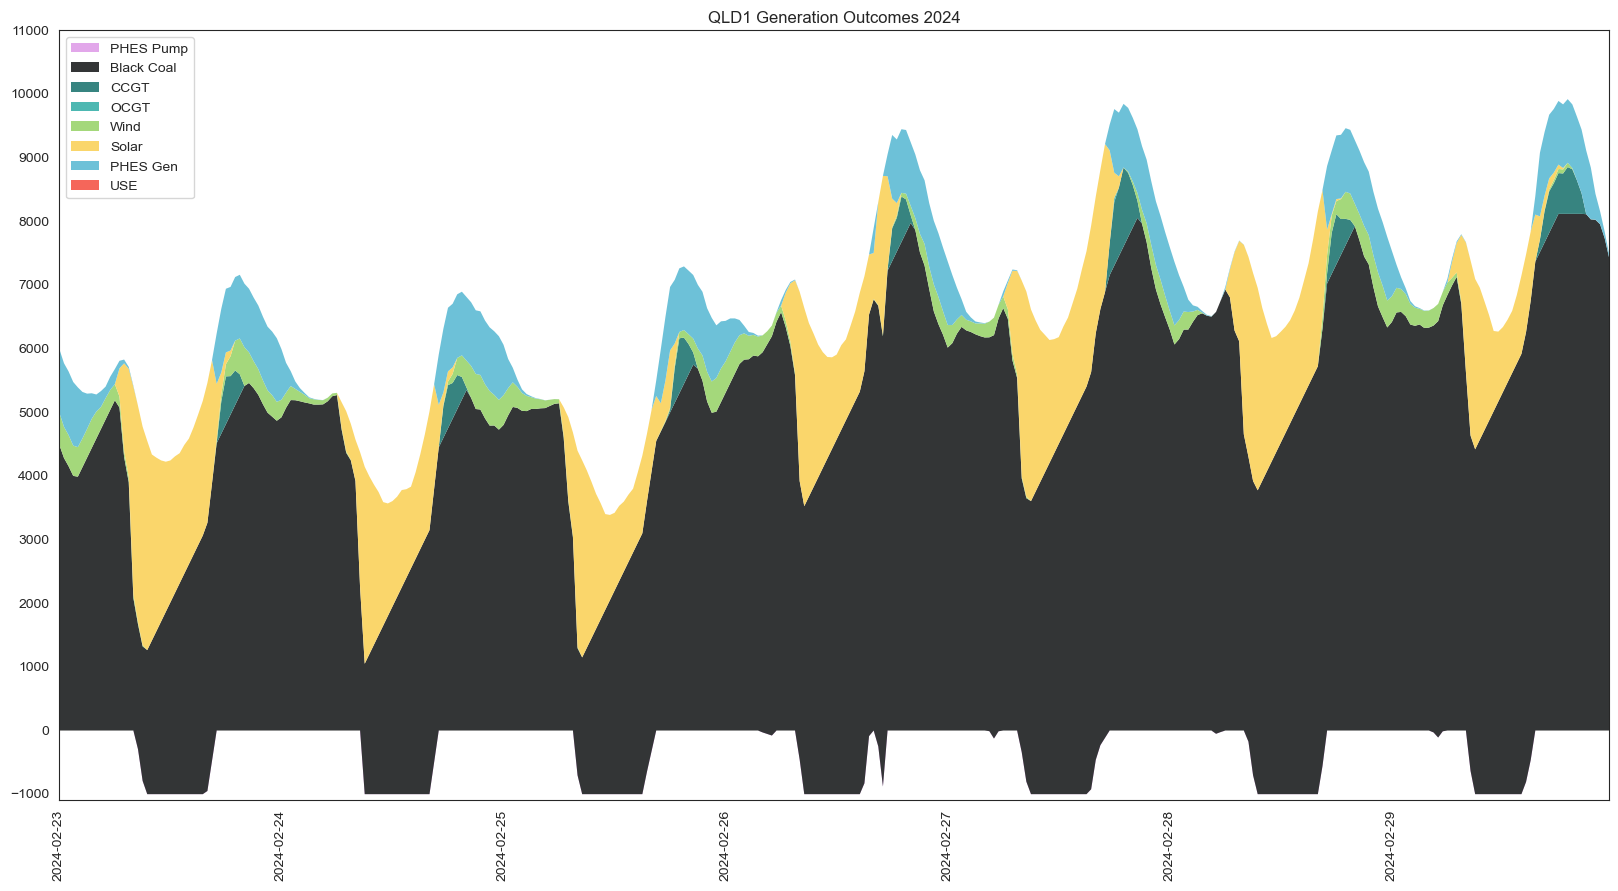

Total System Cost: $55.47 M
Cost per MWh: $50.20
Total USE: 0.00 MWh


In [273]:
# SHow results using an area plot
sns.set_style('white')

plt.figure(figsize=(20, 10))
plt.stackplot(df['IntervalEnd'], df['phes_pump'], df['black_coal'], df['ccgt'], df['ocgt'], df['wind'], df['solar'], df['phes_gen'], df['use'], labels=['PHES Pump', 'Black Coal', 'CCGT', 'OCGT', 'Wind', 'Solar', 'PHES Gen', 'USE'], linewidth=0, colors=technologies)
plt.title('QLD1 Generation Outcomes 2024')
plt.xlim(df['IntervalEnd'].min(), df['IntervalEnd'].max())
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.ylim(-1100, 11000)
plt.yticks(np.arange(-1000, 11000+1, 1000))
plt.legend(loc='upper left')

# Plot storage level on a secondary axis
# plt.twinx()
# sns.lineplot(data=df, x='IntervalEnd', y='phes_energy', color='grey', label='Storage Level', linewidth=2)

plt.show()

print(f"Total System Cost: ${value(prob.objective)/1e6:.2f} M")
print(f"Cost per MWh: ${value(prob.objective)/df['demand'].sum()*2:.2f}")
print(f"Total USE: {df['use'].sum()/2:.2f} MWh")

In [274]:
df

,IntervalEnd,demand,wind_trace,solar_trace,phes_gen,phes_pump,phes_energy,black_coal,ccgt,ocgt,wind,solar,use
0,2024-02-23 00:00:00,5995.065735,0.495426,0.0,1000.000000,-0.0,4000.000000,4488.2449,0.0,0.0,506.820800,0.0,0
1,2024-02-23 00:30:00,5772.298061,0.478402,0.0,1000.000000,-0.0,3500.000000,4282.8928,0.0,0.0,489.405250,0.0,0
2,2024-02-23 01:00:00,5642.069754,0.478402,0.0,1000.000000,-0.0,3000.000000,4152.6645,0.0,0.0,489.405250,0.0,0
3,2024-02-23 01:30:00,5476.941578,0.464660,0.0,1000.000000,-0.0,2500.000000,4001.5944,0.0,0.0,475.347180,0.0,0
4,2024-02-23 02:00:00,5391.924279,0.454164,0.0,938.115470,-0.0,2000.000000,3989.1990,0.0,0.0,464.609770,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2024-02-29 21:30:00,8845.318750,0.001775,0.0,811.538660,-0.0,811.538660,8031.9643,0.0,0.0,1.815825,0.0,0
332,2024-02-29 22:00:00,8433.090700,0.001542,0.0,405.769330,-0.0,405.769330,8025.7439,0.0,0.0,1.577466,0.0,0
333,2024-02-29 22:30:00,8158.779548,0.000441,0.0,202.884660,-0.0,202.884660,7955.4437,0.0,0.0,0.451143,0.0,0
334,2024-02-29 23:00:00,7835.724701,0.000000,0.0,101.442330,-0.0,101.442330,7734.2824,0.0,0.0,0.000000,0.0,0


In [275]:
# Show all rows where both phes_gen and phes_pump are above 0
df[(df['phes_gen'] > 0) & (df['phes_pump'] < 0)]

,IntervalEnd,demand,wind_trace,solar_trace,phes_gen,phes_pump,phes_energy,black_coal,ccgt,ocgt,wind,solar,use
